In [66]:
import os 
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as keras
from sklearn.preprocessing import StandardScaler, RobustScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, accuracy_score, \
    precision_recall_curve, average_precision_score, balanced_accuracy_score, matthews_corrcoef, roc_curve, auc
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
os.getcwd()

'C:\\Users\\mdsou'

In [3]:
os.chdir('Downloads')

In [4]:
os.listdir()

['CAI_GRU_Test.ipynb',
 'CAI_Project2_GRU.ipynb',
 'desktop.ini',
 'Matthew_Southworth_CV2024.docx',
 'model_GRU.keras',
 'Project 2.pdf',
 'training-validation',
 '~$M A3 Credit Card Transactions Solutions.docx',
 '~$nalProject.docx',
 '~WRL2591.tmp']

# Data Extraction and Preprocessing

In [5]:
directory = "training-validation" 

In [6]:
sub_folders = os.listdir(directory)
sub_folders

['sub01', 'sub02', 'sub03', 'sub05']

In [7]:
path = os.path.join(directory, sub_folders[0])

In [8]:
r = []
for root, dirs, files in os.walk(directory):
    for name in files:
        filepath = root + os.sep + name
        if filepath.endswith(".csv"):
            r.append(os.path.join(root, name))
    

In [9]:
files = []
for file in r:
    #for dir, dir_name, file_list in os.walk(path):
    files.append(os.path.join(path, file))

In [10]:
df = []
df = pd.read_csv(r[0], header=None)
for file in r[1:]:
    temp = pd.read_csv(file, header=None)
    df = pd.concat([df, temp])

In [11]:
df.head()

,0,1,2,3,4
0,0,142,60,100,0
1,1,142,60,100,0
2,2,142,60,100,0
3,3,142,59,100,0
4,4,143,59,100,0


In [13]:
df.drop(df.columns[0], axis=1, inplace=True)

In [14]:
df.isna().sum()

1    0
2    0
3    0
4    0
dtype: int64

In [15]:
df[1].describe()

count    18662.000000
mean       157.737917
std         51.928414
min         -1.000000
25%        149.000000
50%        160.000000
75%        170.000000
max       4164.000000
Name: 1, dtype: float64

In [16]:
df[2].describe()

count    18662.000000
mean        43.206141
std         16.794824
min         -1.000000
25%         34.000000
50%         45.000000
75%         55.000000
max        105.000000
Name: 2, dtype: float64

In [17]:
df[3].describe()

count     18662
unique       51
top         100
freq       4279
Name: 3, dtype: int64

In [18]:
df[4].value_counts()

4
0    9827
1    6541
#    1178
2    1116
Name: count, dtype: int64

# Dropping invalid values

In [19]:
df = df[df[1] != '-1']

In [20]:
df = df[df[1] != -1]

In [21]:
df = df[df[2] != -1]

In [22]:
df = df[df[1] != '--1']

In [23]:
df = df[df[4] != '#']

In [24]:
df = df[df[3] != '--1']

In [25]:
df = df.reset_index(drop=True)

In [26]:
x = df.drop([4], axis = 1)
y = df[4]

In [27]:
y.unique()

array([0, 1, 2], dtype=object)

In [28]:
y = y.astype(np.int32)

In [29]:
#y_onehot = to_categorical(y, 3)

In [29]:
x[3].dtype

dtype('O')

In [30]:
x[3] = x[3].astype(int)

In [31]:
timestep = 30

# Create timesteps

In [32]:
def create_timestep(x, y, timestep=timestep):
    x_step = []
    y_step = []
    for i in range(len(x) - timestep):
        x_step.append(x[i:i+timestep])
        y_step.append(y[i+timestep])
    return np.array(x_step), np.array(y_step)

In [33]:
x_step, y_step = create_timestep(x, y)

In [34]:
#For actual sequence data do not shuffle - recombine after scaling
x_train, x_test, y_train, y_test = train_test_split(x_step, y_step,
                                                    stratify=y_step,
                                                    test_size=0.1, 
                                                    random_state=42, shuffle=True)

In [35]:
print(x_train.shape[1])
print(x_train.shape[2])

30
3


In [36]:
#Reshape for scaling
num_steps, num_features = x_train.shape[1], x_train.shape[2]
x_train_flat = x_train.reshape(-1, num_features)
x_test_flat = x_test.reshape(-1, num_features)

In [37]:
x_train_flat

array([[197,  42,  -1],
       [197,  42,  -1],
       [197,  42,  -1],
       ...,
       [196,  12,  -1],
       [197,  12,  -1],
       [197,  39,  -1]], dtype=int64)

# Use Robust Scalar

In [38]:
scaler = RobustScaler()

In [39]:
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

In [42]:
x_train_scaled = x_train_scaled.reshape(-1, num_steps, num_features)
x_test_scaled = x_test_scaled.reshape(-1, num_steps, num_features)
x_train_scaled.shape

(15019, 30, 3)

In [43]:
y_train.shape

(15019,)

In [45]:
print(len(x_train_scaled), x_train_scaled.dtype)
print(len(y_train), y_train.dtype)
print(len(x_test_scaled), x_test_scaled.dtype)
print(len(y_test), y_test.dtype)
#Verify same length

15019 float64
15019 int32
1669 float64
1669 int32


# Use class weight for balancing classes

In [46]:
#Cant use one hot encoding with class weights - Use sparse categorical and add to model
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

In [47]:
class_weight_dict

{0: 0.5895753985047256, 1: 0.9014342715410331, 2: 5.140836408364084}

# Model

In [48]:
model = keras.models.Sequential()
# Need 3 dimensional shape
model.add(layers.LSTM(16, return_sequences=True, input_shape=(20, 3)))
model.add(layers.LSTM(32, return_sequences=True))
#Add BN
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.LSTM(30, activation='relu', return_sequences=True))
model.add(layers.LSTM(30)) #Return sequence false for final layer -> BS, units = final layer
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(3, activation = "softmax", kernel_regularizer=regularizers.l2(0.001)))
model.summary()

C:\Users\mdsou\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 16)              │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 32)              │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 20, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 20, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 20, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 20, 30)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30)                  │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30)                  │             120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              93 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,701 (201.96 KB)

 Trainable params: 51,449 (200.97 KB)

 Non-trainable params: 252 (1008.00 B)

In [49]:
lr = 0.0001
batch_size = timestep

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate= lr)

In [78]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5#, min_lr = 0.0001
                             )
model_save = tf.keras.callbacks.ModelCheckpoint(filepath=f'model_LSTM.keras',
                                                monitor='val_accuracy', save_best_only=True)

In [79]:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_scaled, y_train, epochs = 30, batch_size = batch_size, callbacks=[early_stop, reduce_lr, model_save],
 validation_data=(x_test_scaled, y_test), verbose = 1, class_weight=class_weight_dict)

Epoch 1/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.8964 - loss: 0.2582 - val_accuracy: 0.9227 - val_loss: 0.1920 - learning_rate: 1.0000e-04
Epoch 2/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 51s 61ms/step - accuracy: 0.8982 - loss: 0.2589 - val_accuracy: 0.9383 - val_loss: 0.1799 - learning_rate: 1.0000e-04
Epoch 3/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.8987 - loss: 0.2599 - val_accuracy: 0.9299 - val_loss: 0.1923 - learning_rate: 1.0000e-04
Epoch 4/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.9062 - loss: 0.2417 - val_accuracy: 0.9149 - val_loss: 0.2150 - learning_rate: 1.0000e-04
Epoch 5/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/step - accuracy: 0.9109 - loss: 0.2288 - val_accuracy: 0.9371 - val_loss: 0.1733 - learning_rate: 1.0000e-04
Epoch 6/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9105 - loss: 0.2275 - val_accuracy: 0.9395 - val_loss: 0.1692 - learning_rate: 1.0000e-04
Epoch 7/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 46s 63ms/ste

# Plot training history

In [54]:
def plot_training_history(history):
    """
    Create function to call accuracy and validation plots
    """
    plt.rcParams["figure.figsize"] = (10, 5)

    # accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

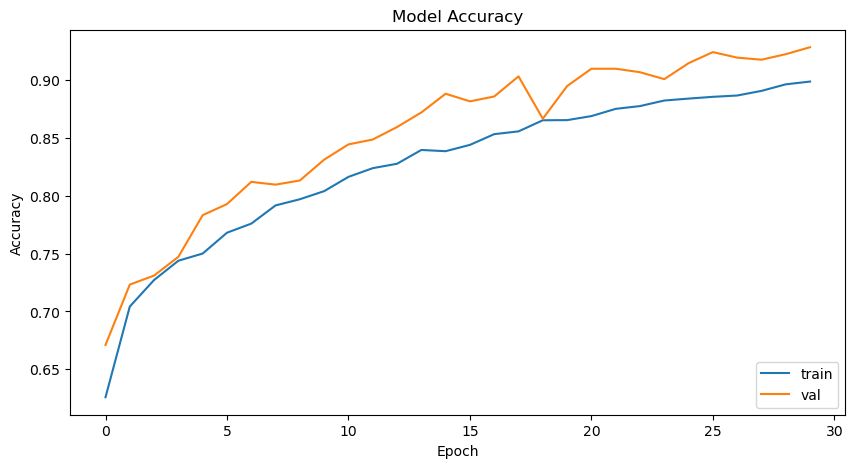

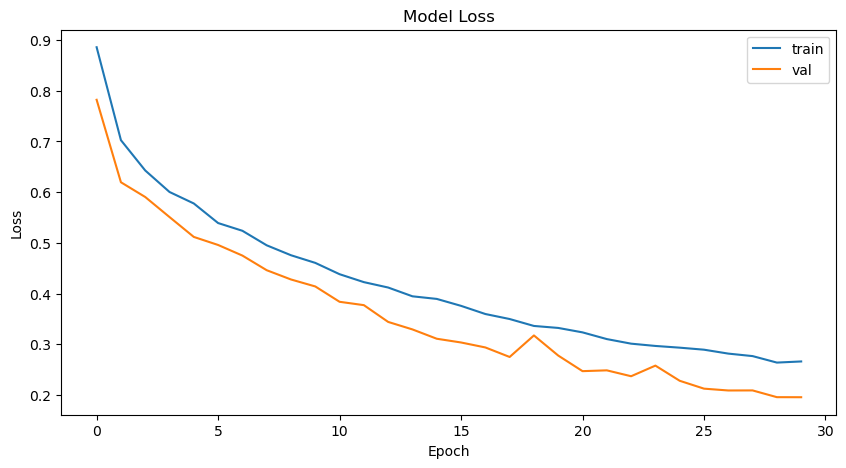

In [55]:
plot_training_history(history)

# Metrics

In [56]:
#Get predictions
y_probs = model.predict(x_test_scaled)
y_pred = np.argmax(y_probs, axis=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [57]:
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9281006590772918


In [58]:
# Precision, Recall, F1
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision} \nRecall: {recall} \nF1 Score: {f1}')

Precision: 0.9280454234229429 
Recall: 0.9281006590772918 
F1 Score: 0.9277694764281993


# AUC and ROC plot

In [65]:
# AUC - inherently binary - uses ovr
roc_auc_value = roc_auc_score(y_test, y_probs, multi_class='ovr')
print(auc)

0.988474040252601


In [63]:
from sklearn.preprocessing import label_binarize #Needed since AUC is for binary - OvR

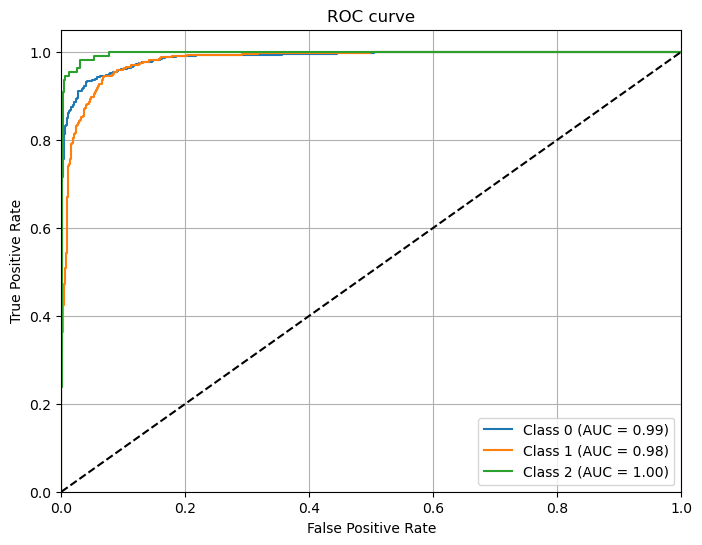

In [68]:
n_classes = y_probs.shape[1]
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs [:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    label = f"Class {i}" 
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [69]:
# PR-AUC - Average precision
pr_auc = average_precision_score(y_test, y_probs)
print(pr_auc)

0.9710211175124949


In [70]:
# Matthew's Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(mcc)

0.8664811197802574


In [71]:
# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(bal_acc)

0.9225459350692028


# Confusion Matrix

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion(cm, title="Confusion Matrix"):

    plt.rcParams["figure.figsize"] = (8, 6)
    fig, ax = plt.subplots()
    
    cax = ax.matshow(cm, cmap='Wistia')
    fig.colorbar(cax)

    # Add text annotations inside each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), va='center', ha='center', color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=12, weight='bold')

    class_names = [str(cls) for cls in np.unique(y_test)]
        
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names)
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


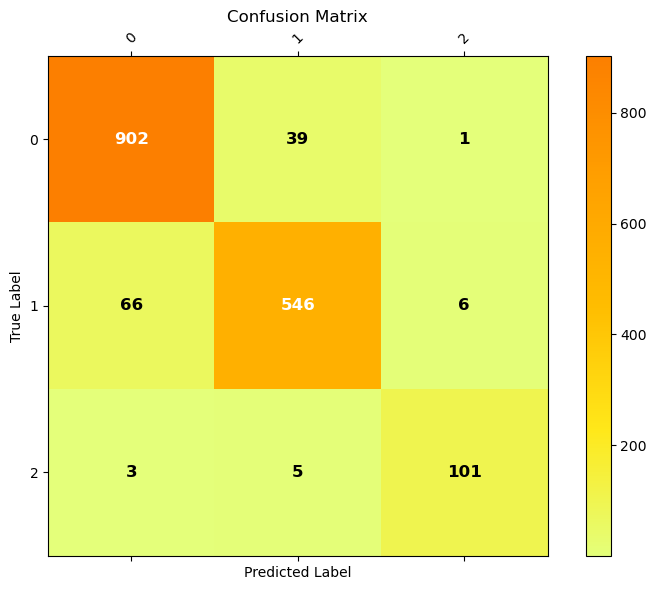

In [73]:
cm = confusion_matrix(y_test, y_pred)

plot_confusion(cm)

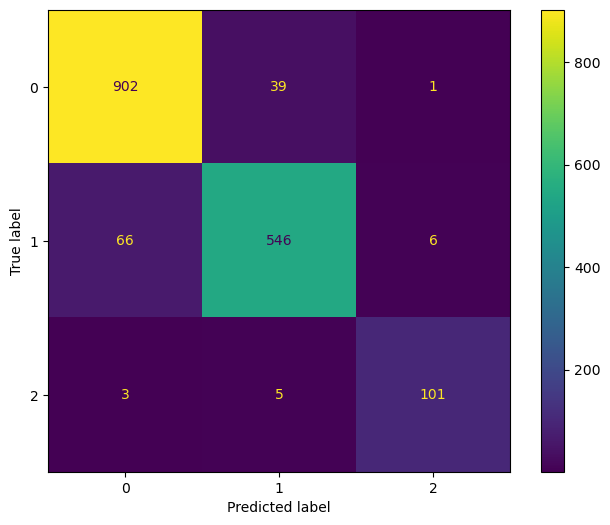

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            )
disp.plot()

plt.show()

# True Negative Rate

In [75]:
true_neg = []
for i in range(3):
    # One-v-Rest: class i is positive, all others negative
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    true_neg.append(tnr)

In [76]:
labels = np.unique(y_test)
for label, rate in zip(labels, true_neg):
    print(f"Class {label}: True Negative Rate: {rate:.4f}")

Class 0: True Negative Rate: 0.9051
Class 1: True Negative Rate: 0.9581
Class 2: True Negative Rate: 0.9955


# Testing

In [77]:
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f"GRU Model Test Accuracy: {accuracy:.4f} \nLoss: {loss:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9241 - loss: 0.1995
GRU Model Test Accuracy: 0.9281 
Loss: 0.1957


# Load and Test Script

In [ ]:
df_test = pd.read_csv('path/to/file.csv', header=None)

In [ ]:
df_test.drop(df_test.columns[0], axis=1, inplace=True)

In [ ]:
df_test = df[df[4] != '#']

In [ ]:
df_test = df.reset_index(drop=True)

In [ ]:
x_test_set = df_test.drop([4], axis = 1)
y_test_set = df_test[4]

In [ ]:
x_test_set = scaler.transform(x_test_set)

In [ ]:
def create_timestep(x, y, timestep=timestep):
    x_step = []
    y_step = []
    for i in range(len(x) - timestep):
        x_step.append(x[i:i+timestep])
        y_step.append(y[i+timestep])
    return np.array(x_step), np.array(y_step)

In [ ]:
x_step_test, y_step_test = create_timestep(x_test_set, y_test_set)

In [ ]:
checkpoint_path = "model_LSTM.keras"

In [ ]:
model = tf.keras.models.load_model(checkpoint_path)

In [ ]:
loss, acc = model.evaluate(x_step_test, y_step_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
y_probs = model.predict(x_step_test)
y_pred = np.argmax(y_probs, axis=1)

In [ ]:
output = pd.DataFrame({'Predicted': y_pred})
output.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv")